# Time Series Models Comparison & Results
We load the models trained in the Notebooks corresponding to the standardisation and normalisation data transformation and compare the results of these two types of transformations.

In addition, in this notebook we take the results saved in the other two notebooks and analyse and plot the results.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import math
from scipy import spatial

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib.ticker import FormatStrFormatter
import imageio
%matplotlib notebook

import plotly.graph_objects as go

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Data
The stock market time series data is downloaded from Yahoo Finance using yfinance and is saved in order to always use the same dataset.

In [2]:
try:
    data = np.load('time_series_data.npy')
except:
    df = pd.read_csv('companylist.csv')
    tickers_full = np.array(df.Symbol.values)
    
    tickers = tickers_full[np.unique(np.random.randint(low=0, high=len(tickers_full)-1, size=500))]
    tickers_name = ' '.join(tickers)
    raw_data = yf.download(tickers_name, period='1d', start='2000-1-1')

    data = []
    for tick in raw_data.Open.columns:
        aux = np.array(raw_data.Open[tick].values)
        aux = aux[~np.isnan(aux)]
        data.extend(aux[:365 * (len(aux)//365)].reshape((-1, 365)))
    data = np.array(data)
    np.save('time_series_data', data)
    data.shape

In [3]:
# We create the scalers
scaler_minmax = MinMaxScaler()
scaler_minmax.fit(data.T)
scaler_minmax.data_max_
normalized_data = scaler_minmax.transform(data.T).T

scaler_st = StandardScaler()
scaler_st.fit(data.T)
standard_data = scaler_st.transform(data.T).T

In [5]:
# We transform the data into tensors
X_train_minmax = torch.from_numpy(normalized_data).type(torch.FloatTensor)
X_train_st = torch.from_numpy(standard_data).type(torch.FloatTensor)
input_shape = 365

## Autoencoder
This model contains only one hidden layer and its dimension is a parameter.

In [6]:
class NNAutoencoder(nn.Module):
    def __init__(self, input_shape, encode_shape):
        super().__init__()
        self._encode_layer = nn.Linear(in_features=input_shape, out_features=encode_shape)
        self._decode_layer = nn.Linear(in_features=encode_shape, out_features=input_shape)
        self._encode_shape = encode_shape
        
    def encode(self, X):
        return torch.tanh(self._encode_layer(X))
    
    def decode(self, X):
        return torch.tanh(self._decode_layer(X))

    def forward(self, X):
        return self.decode(self.encode(X))
    
    def predict(self, X):
        return self.forward(X).clone().detach()
    
    def train(self, X, y, epochs, optimizer, criterion, plot=False, **kwargs):
        losses = []
        im = []
        for i in range(epochs):
            optimizer.zero_grad()
            
            y_pred = self.forward(X)
            loss = criterion(y_pred, y)
            
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
        return losses

# Load Models

In [7]:
model_1_st = NNAutoencoder(input_shape=input_shape, encode_shape=1)
model_1_st.load_state_dict(torch.load("models/ae_1_st"))
model_2_st = NNAutoencoder(input_shape=input_shape, encode_shape=2)
model_2_st.load_state_dict(torch.load("models/ae_2_st"))
model_3_st = NNAutoencoder(input_shape=input_shape, encode_shape=3)
model_3_st.load_state_dict(torch.load("models/ae_3_st"))
model_5_st = NNAutoencoder(input_shape=input_shape, encode_shape=5)
model_5_st.load_state_dict(torch.load("models/ae_5_st"))
model_10_st = NNAutoencoder(input_shape=input_shape, encode_shape=10)
model_10_st.load_state_dict(torch.load("models/ae_10_st"))
model_30_st = NNAutoencoder(input_shape=input_shape, encode_shape=30)
model_30_st.load_state_dict(torch.load("models/ae_30_st"))

<All keys matched successfully>

In [8]:
model_1_mm = NNAutoencoder(input_shape=input_shape, encode_shape=1)
model_1_mm.load_state_dict(torch.load("models/ae_1_mm"))
model_2_mm = NNAutoencoder(input_shape=input_shape, encode_shape=2)
model_2_mm.load_state_dict(torch.load("models/ae_2_mm"))
model_3_mm = NNAutoencoder(input_shape=input_shape, encode_shape=3)
model_3_mm.load_state_dict(torch.load("models/ae_3_mm"))
model_5_mm = NNAutoencoder(input_shape=input_shape, encode_shape=5)
model_5_mm.load_state_dict(torch.load("models/ae_5_mm"))
model_10_mm = NNAutoencoder(input_shape=input_shape, encode_shape=10)
model_10_mm.load_state_dict(torch.load("models/ae_10_mm"))
model_30_mm = NNAutoencoder(input_shape=input_shape, encode_shape=30)
model_30_mm.load_state_dict(torch.load("models/ae_30_mm"))

<All keys matched successfully>

## Load the Predictions

In [23]:
predictions_st = np.load("predictions_st.npy")
predictions_mm = np.load("predictions_mm.npy")

<IPython.core.display.Javascript object>


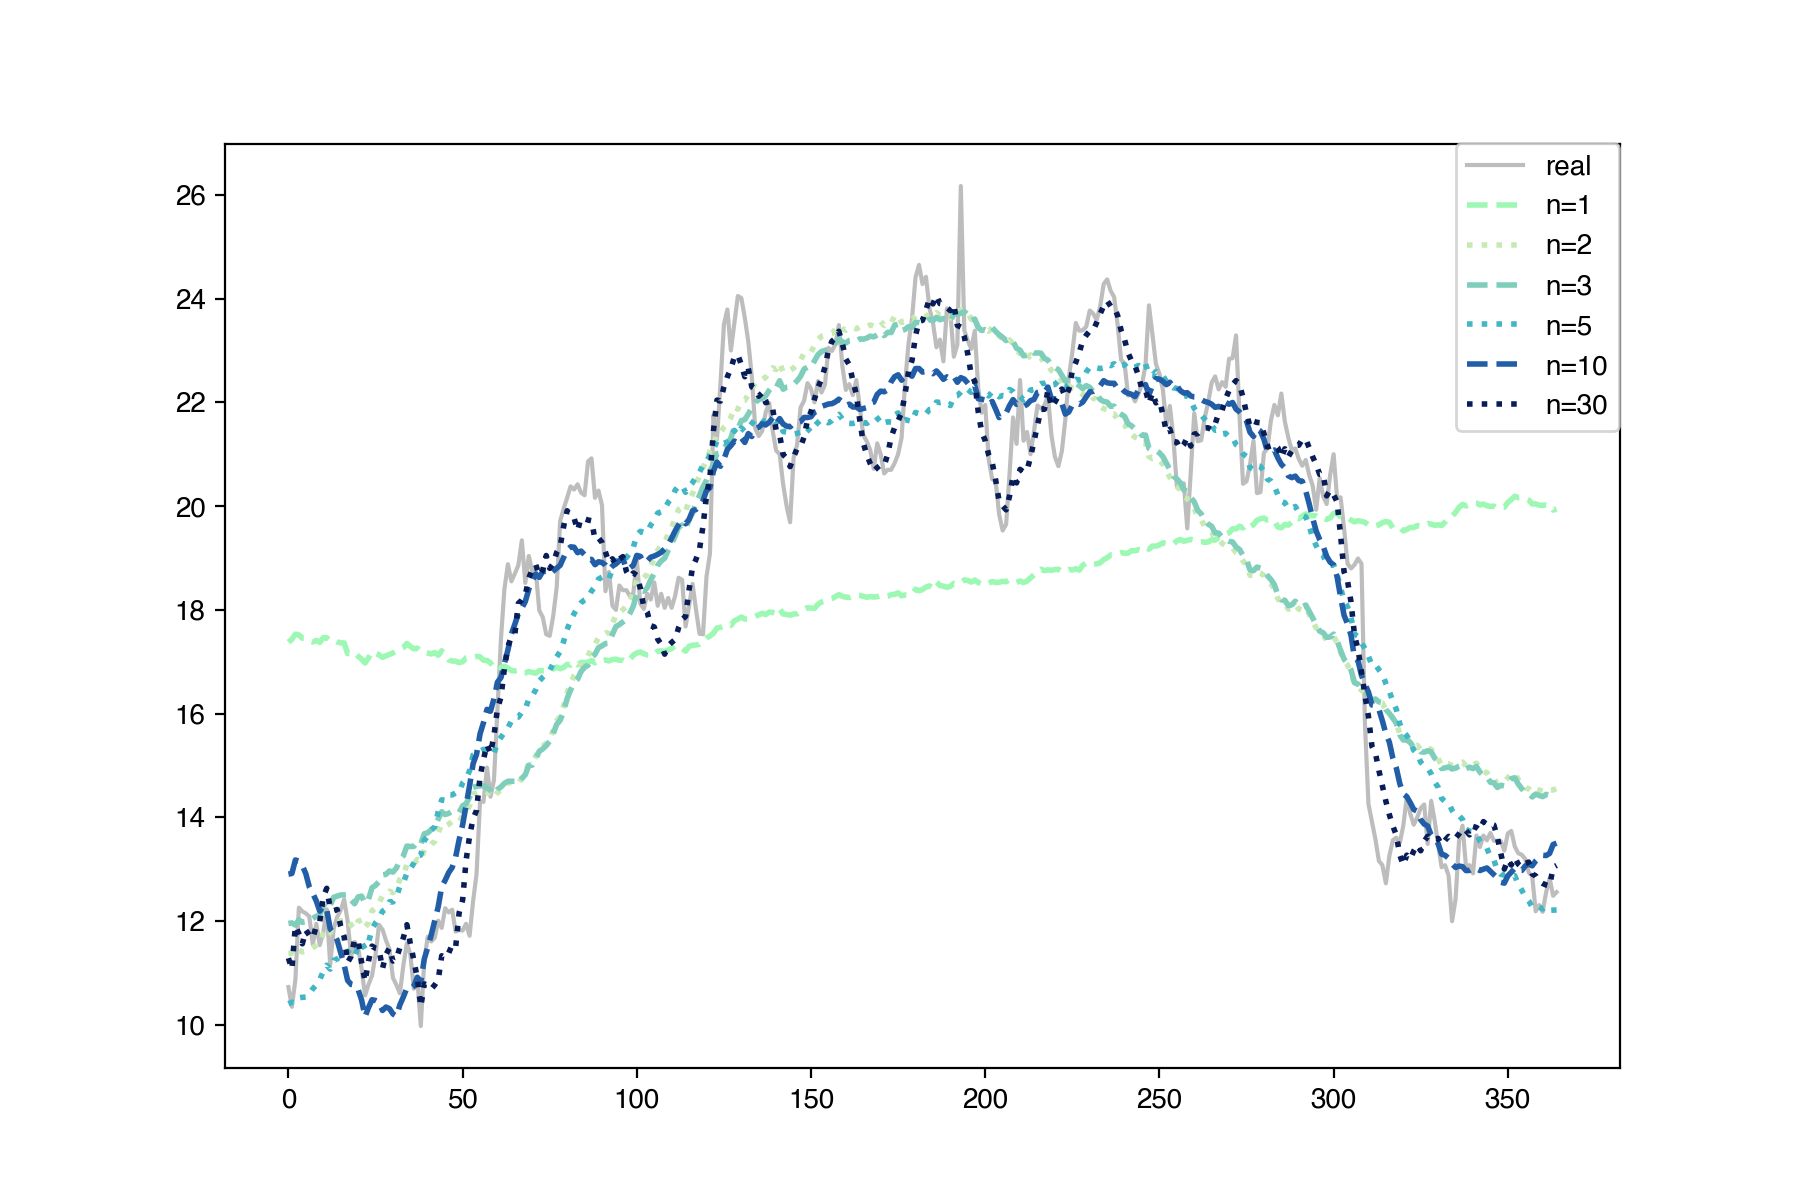

In [40]:
# Result for models trained with standardised data
a = 8

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(data[a], label='real', color='#bdbdbd')

ax.plot(predictions_st[0][a], '--', label='n=1', color='#9df8b4', linewidth=2)
ax.plot(predictions_st[1][a], ':', label='n=2', color='#c7e9b4', linewidth=2)
ax.plot(predictions_st[2][a], '--', label='n=3', color='#7fcdbb', linewidth=2)
ax.plot(predictions_st[3][a], ':', label='n=5', color='#41b6c4', linewidth=2)
ax.plot(predictions_st[4][a], '--', label='n=10', color='#225ea8', linewidth=2)
ax.plot(predictions_st[5][a], ':', label='n=30', color='#081d58', linewidth=2)

fig.legend(loc=1, bbox_to_anchor=(0.907, 0.892))
fig.show()
#plt.savefig('autoencoder_pred_5.png', dpi=300)

<IPython.core.display.Javascript object>


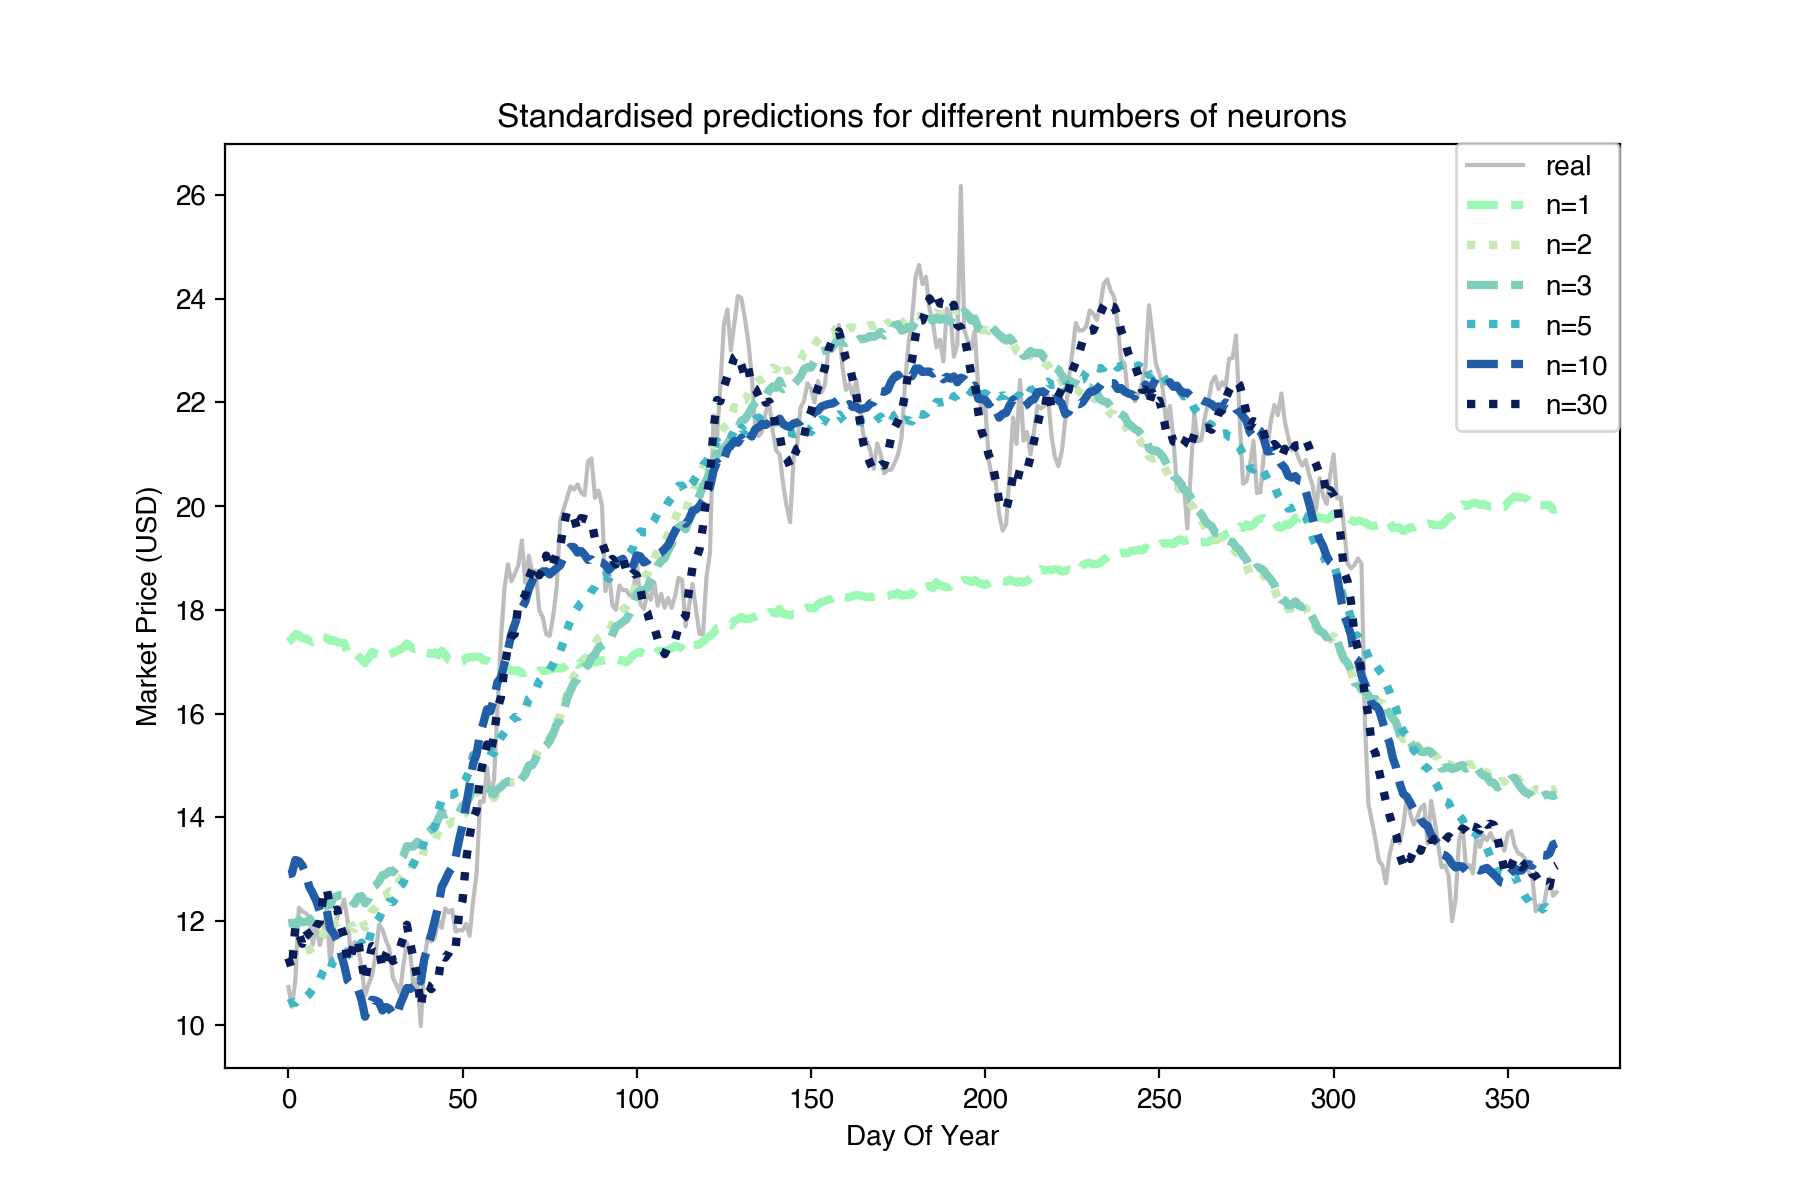

In [183]:
# Result for models trained with normalised data
a = 8

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(data[a], label='real', color='#bdbdbd')

ax.plot(predictions_st[0][a], '--', label='n=1', color='#9df8b4', linewidth=3)
ax.plot(predictions_st[1][a], ':', label='n=2', color='#c7e9b4', linewidth=3)
ax.plot(predictions_st[2][a], '--', label='n=3', color='#7fcdbb', linewidth=3)
ax.plot(predictions_st[3][a], ':', label='n=5', color='#41b6c4', linewidth=3)
ax.plot(predictions_st[4][a], '--', label='n=10', color='#225ea8', linewidth=3)
ax.plot(predictions_st[5][a], ':', label='n=30', color='#081d58', linewidth=3)

ax.set_xlabel("Day Of Year")
ax.set_ylabel("Market Price (USD)")
ax.set_title('Standardised predictions for different numbers of neurons')

fig.legend(loc=1, bbox_to_anchor=(0.907, 0.892))
fig.show()
plt.savefig('ae_pred_st.png', dpi=300)

<IPython.core.display.Javascript object>


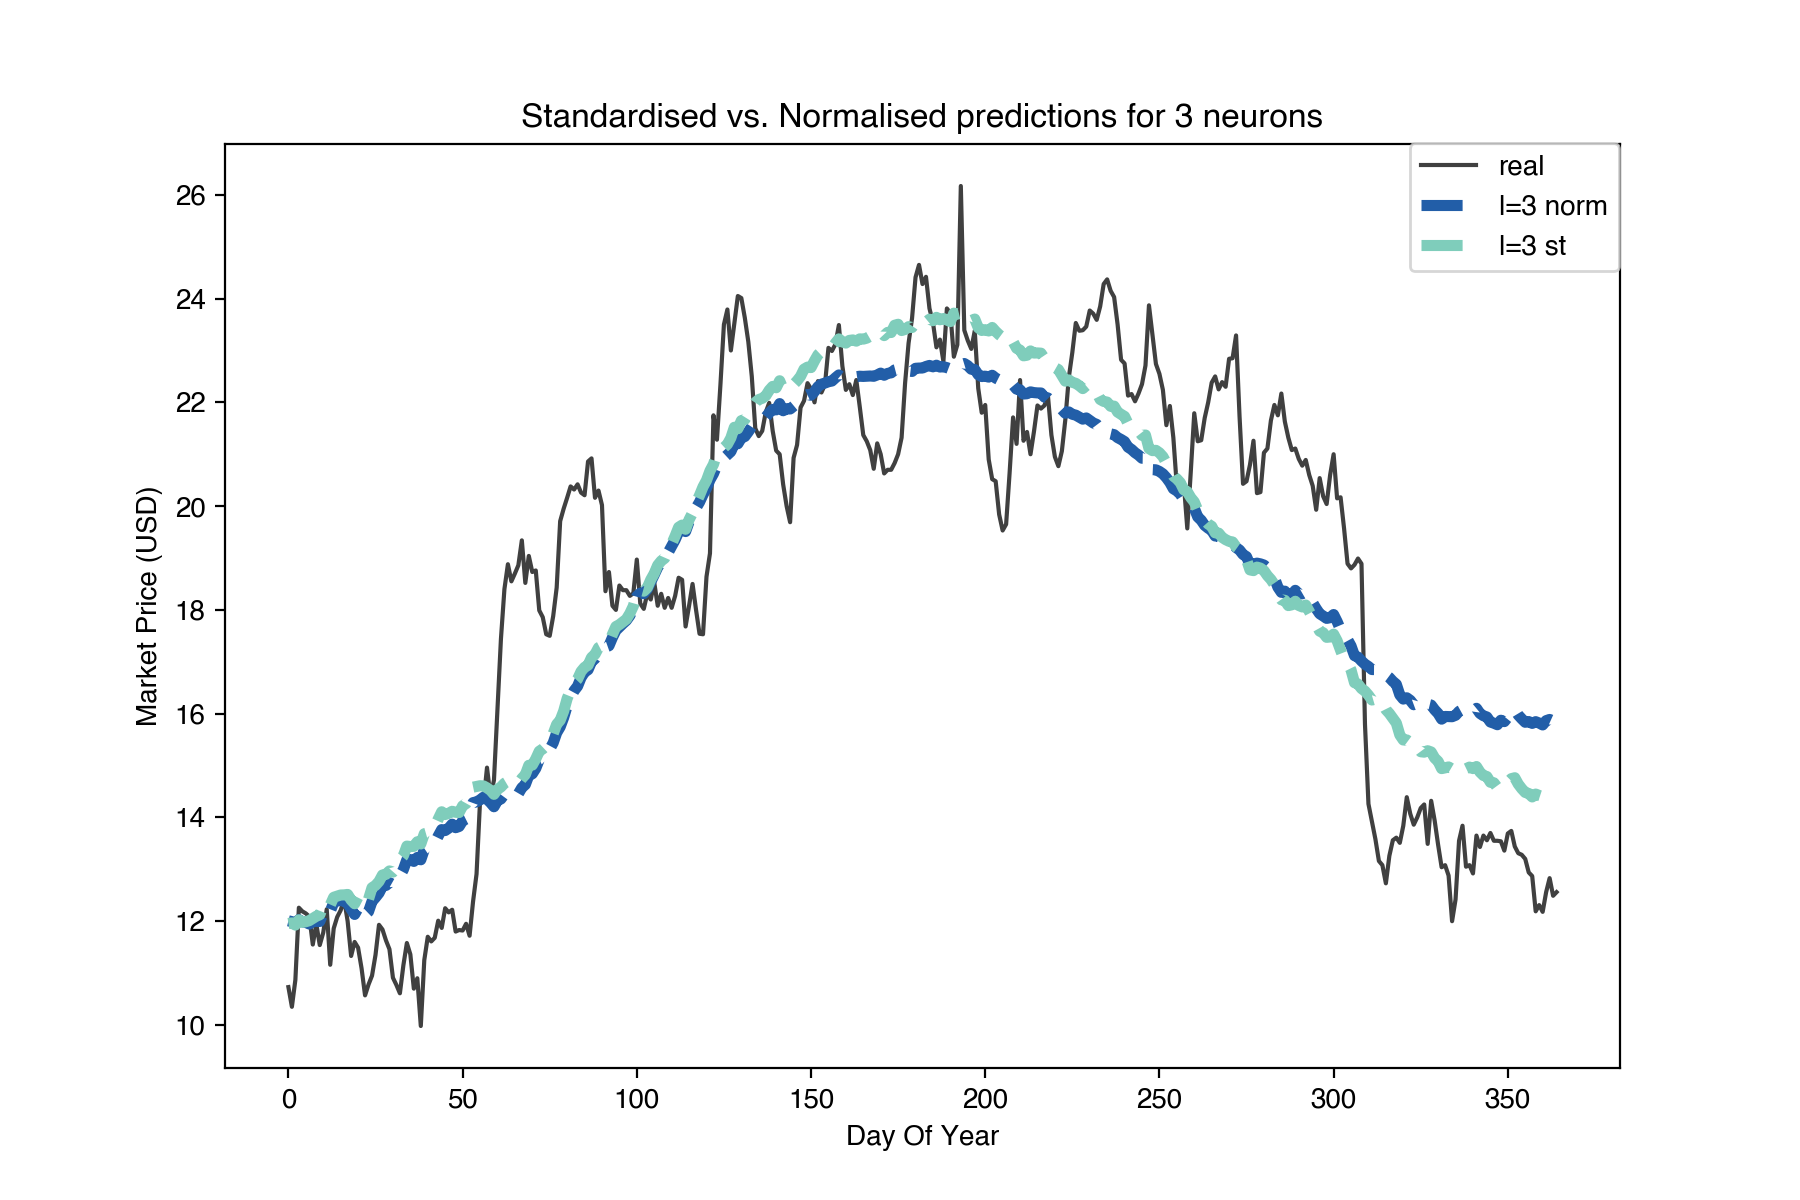

In [182]:
# Comparison between the two transformation methods, for a given number of neurons in the hidden space
a = 8
i = 2
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(data[a], label='real', color='#404040')

ax.plot(predictions_mm[i][a], '--', label='l=3 norm', color='#225ea8', linewidth=4)
ax.plot(predictions_st[i][a], '--', label='l=3 st', color='#7fcdbb', linewidth=4)

ax.set_xlabel("Day Of Year")
ax.set_ylabel("Market Price (USD)")
ax.set_title('Standardised vs. Normalised predictions for 3 neurons')

fig.legend(loc=1, bbox_to_anchor=(0.907, 0.892))
fig.show()
plt.savefig('ae_vs_3.png', dpi=300)

## Losses

In [66]:
losses_st = np.load("losses_st.npy", allow_pickle=True)
losses_mm = np.load("losses_mm.npy", allow_pickle=True)

<IPython.core.display.Javascript object>


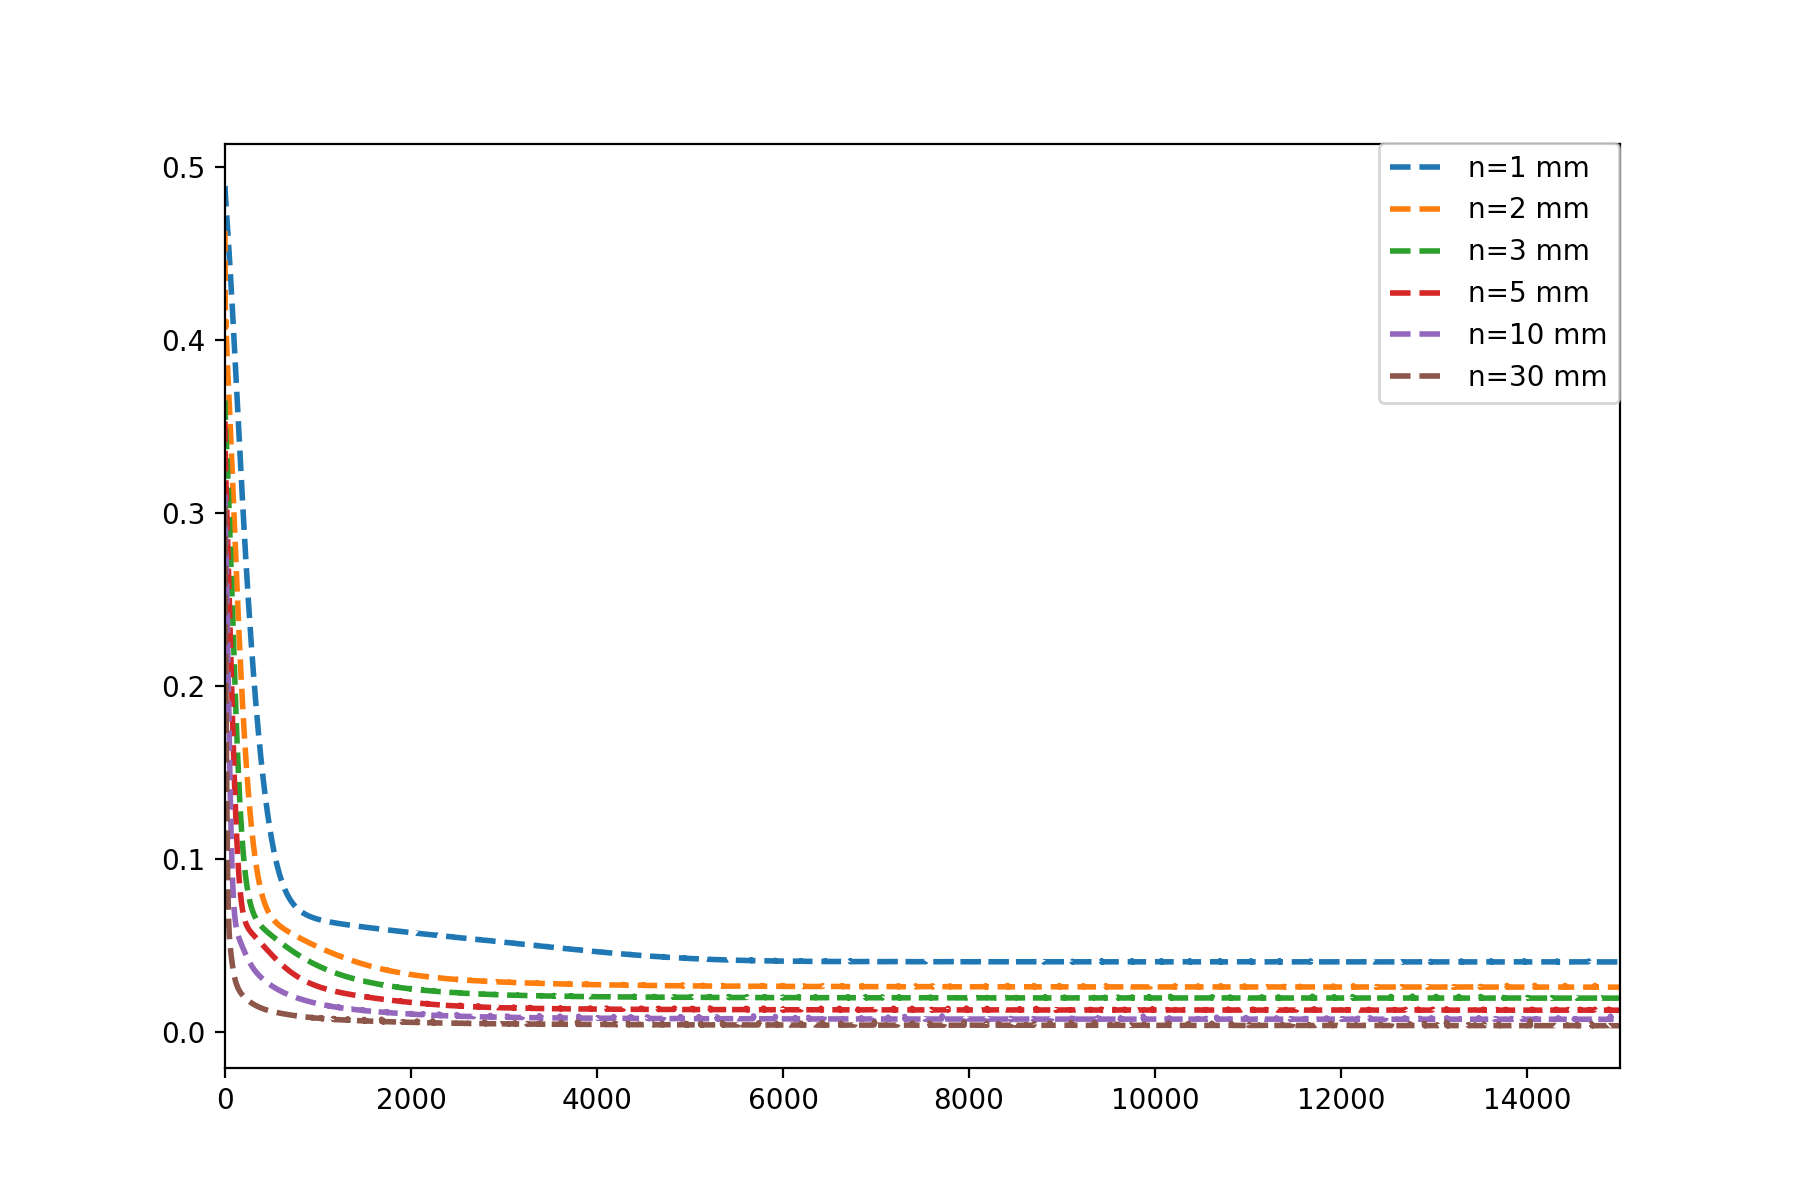

In [75]:
a = 213
i = 5
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(losses_mm[0], '--', label='n=1 mm', linewidth=2)
ax.plot(losses_mm[1], '--', label='n=2 mm', linewidth=2)
ax.plot(losses_mm[2], '--', label='n=3 mm',  linewidth=2)
ax.plot(losses_mm[3], '--', label='n=5 mm', linewidth=2)
ax.plot(losses_mm[4], '--', label='n=10 mm', linewidth=2)
ax.plot(losses_mm[5], '--', label='n=30 mm', linewidth=2)
ax.set_xlim(0,15000)
fig.legend(loc=1, bbox_to_anchor=(0.907, 0.892))
fig.show()
#plt.savefig('autoencoder_pred_5.png', dpi=300)

<IPython.core.display.Javascript object>


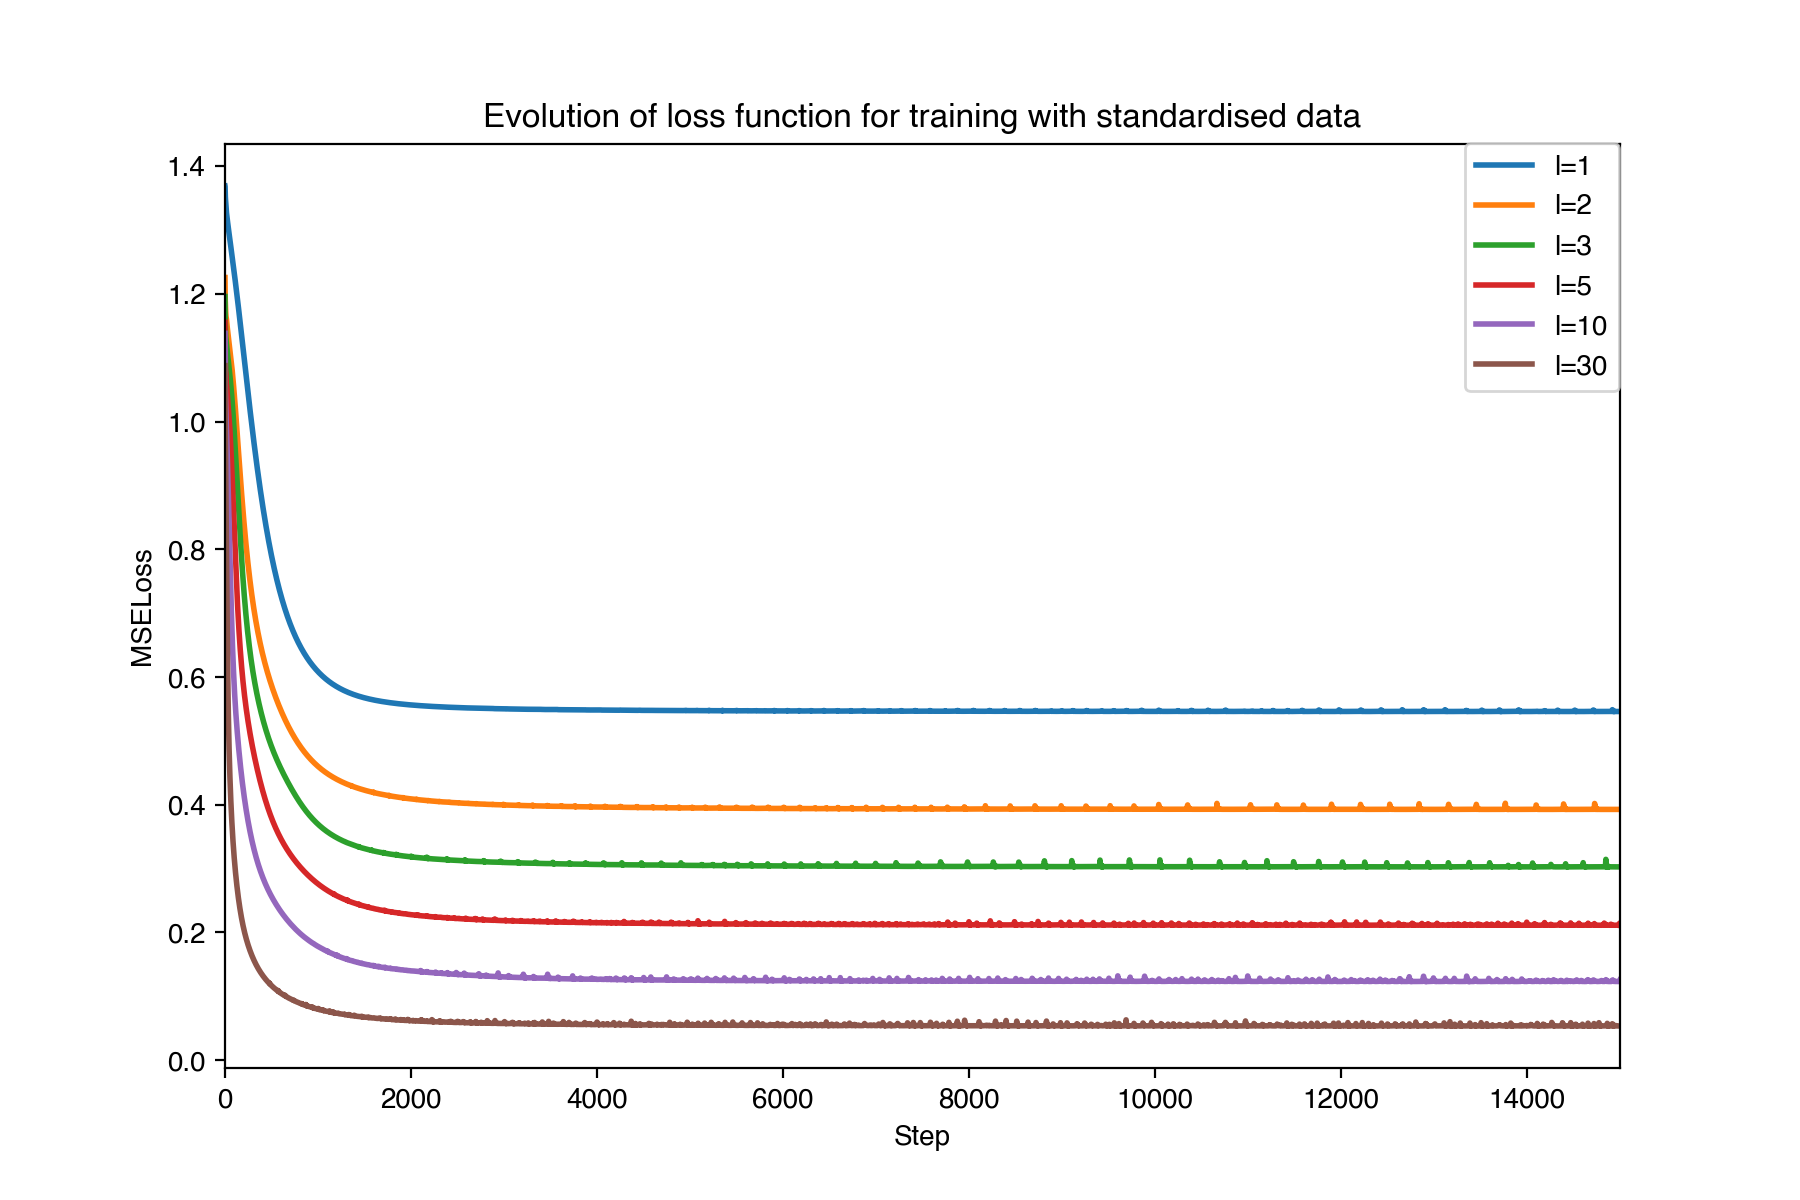

In [89]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(losses_st[0], label='l=1', linewidth=2)
ax.plot(losses_st[1], label='l=2', linewidth=2)
ax.plot(losses_st[2], label='l=3',  linewidth=2)
ax.plot(losses_st[3], label='l=5', linewidth=2)
ax.plot(losses_st[4], label='l=10', linewidth=2)
ax.plot(losses_st[5], label='l=30', linewidth=2)
ax.set_xlim(0,15000)
ax.set_xlabel("Step")
ax.set_ylabel("MSELoss")
ax.set_title('Evolution of loss function for training with standardised data')
fig.legend(loc=1, bbox_to_anchor=(0.907, 0.892))
fig.show()
plt.savefig('loss_st.png', dpi=300)

## Latent Space

Here we load the latent space information and plot the results for N = 2, 3

In [145]:
st_data = np.load('test_st.npy')

In [146]:
st_norm = np.load('test_norm.npy')

In [147]:
test_st = torch.from_numpy(st_data).type(torch.FloatTensor)
test_norm = torch.from_numpy(st_norm).type(torch.FloatTensor)

### Normalised

#### 2

In [149]:
H_2_norm = model_2_mm.encode(test_norm).clone().detach().numpy()
tree_2_norm = spatial.KDTree(H_2_norm)

In [150]:
r = 0.1
y_2_norm = []
for point in H_2_norm:
    y_2_norm.append(len(tree_2_norm.query_ball_point(point, r)) - 1)

<IPython.core.display.Javascript object>


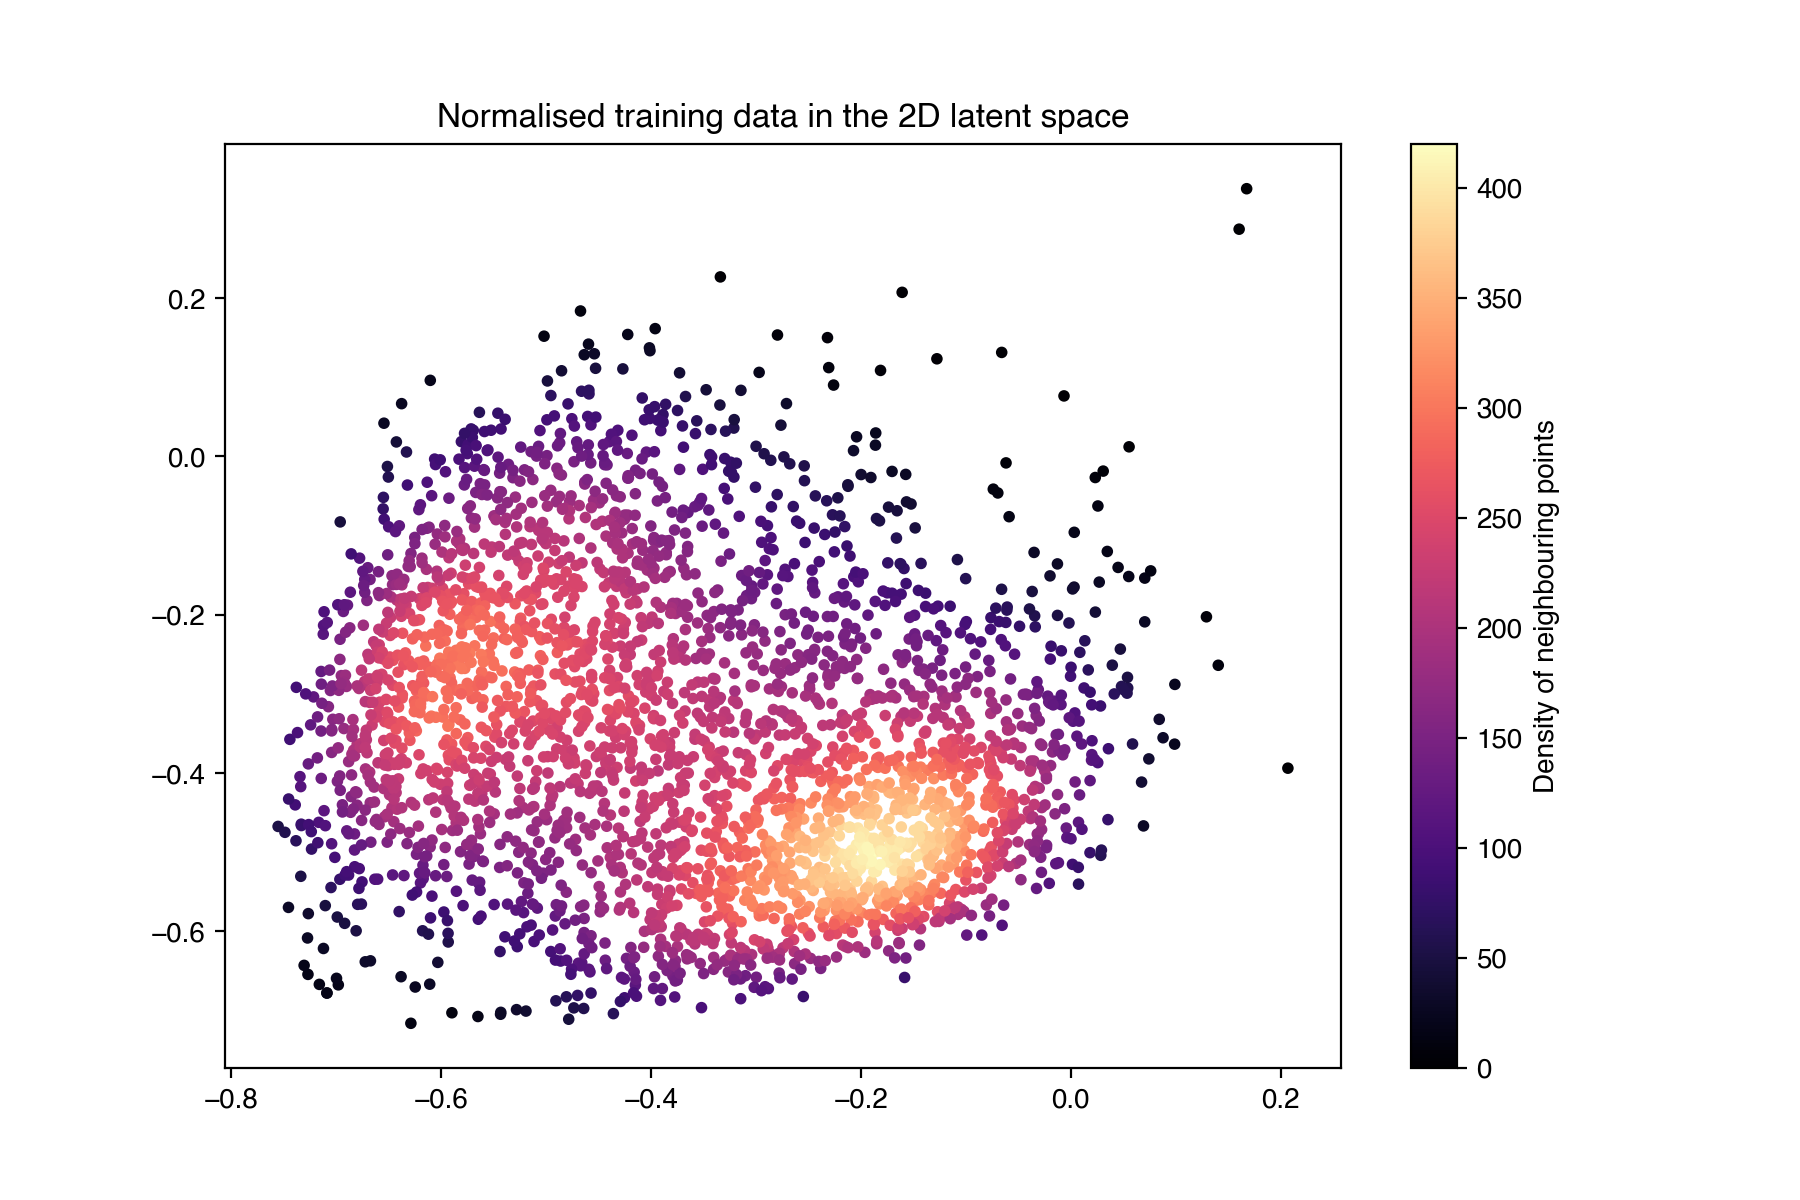

In [173]:
fig, ax = plt.subplots(figsize=(9,6))

im = ax.scatter(H_2_norm[:, 0], H_2_norm[:, 1], s=10, c=y_2_norm, cmap='magma')
fig.colorbar(im, ax=ax).set_label('Density of neighbouring points')
ax.set_title('Normalised training data in the 2D latent space')

fig.show()
plt.savefig('ae_2_latent_norm.png', dpi=300)

In [327]:
d = 0.2
delta_x = torch.from_numpy(np.array([d, 0])).type(torch.FloatTensor)
delta_y = torch.from_numpy(np.array([0, d])).type(torch.FloatTensor)

In [328]:
H_2_norm[:, 1].min()

-0.71617526

In [329]:
p = np.array([-0.2, -0.4])
point = torch.from_numpy(p).type(torch.FloatTensor)

In [330]:
x_plus = model_2_mm.decode(point + delta_x).clone().detach().numpy()
x_minus = model_2_mm.decode(point - delta_x).clone().detach().numpy()
y_plus = model_2_mm.decode(point + delta_y).clone().detach().numpy()
y_minus = model_2_mm.decode(point - delta_y).clone().detach().numpy()
pred = model_2_mm.decode(point).clone().detach().numpy()

<IPython.core.display.Javascript object>


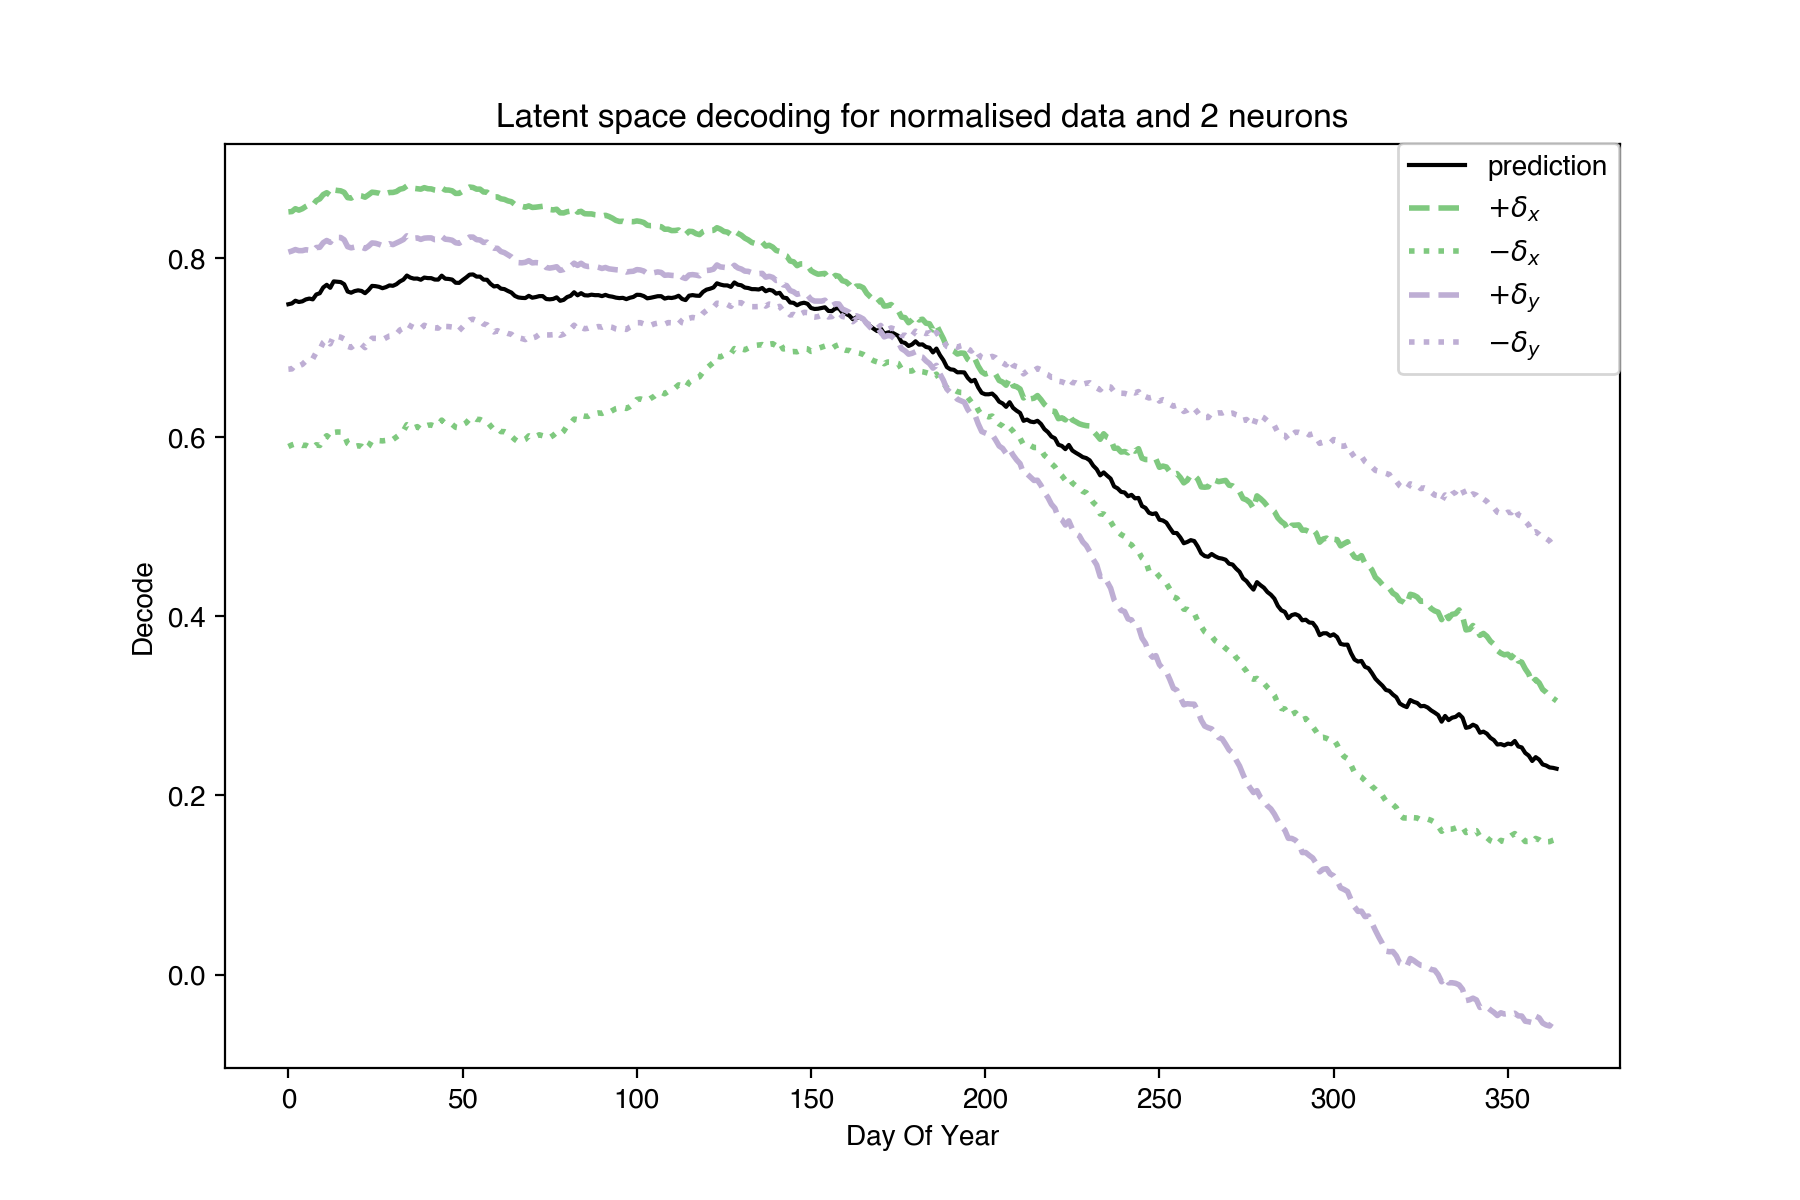

In [397]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(pred, "-", label='prediction', color='black')
ax.plot(x_plus, "--", label=r'$+ \delta_x$', linewidth=2, color='#7fc97f')
ax.plot(x_minus, ":", label=r'$- \delta_x$', linewidth=2, color='#7fc97f')
ax.plot(y_plus, "--", label=r'$+ \delta_y$', linewidth=2, color='#beaed4')
ax.plot(y_minus, ":", label=r'$- \delta_y$', linewidth=2, color='#beaed4')

ax.set_xlabel("Day Of Year")
ax.set_ylabel("Decode")
ax.set_title('Latent space decoding for normalised data and 2 neurons')
fig.legend(loc=1, bbox_to_anchor=(0.907, 0.892))
fig.show()
plt.savefig('ae_2_decode_norm.png', dpi=300)

#### 3

In [213]:
H_3_norm = model_3_mm.encode(test_norm).clone().detach().numpy()
tree_3_norm = spatial.KDTree(H_3_norm)

In [214]:
r = 0.1
y_3_norm = []
for point in H_3_norm:
    y_3_norm.append(len(tree_3_norm.query_ball_point(point, r)) - 1)

<IPython.core.display.Javascript object>


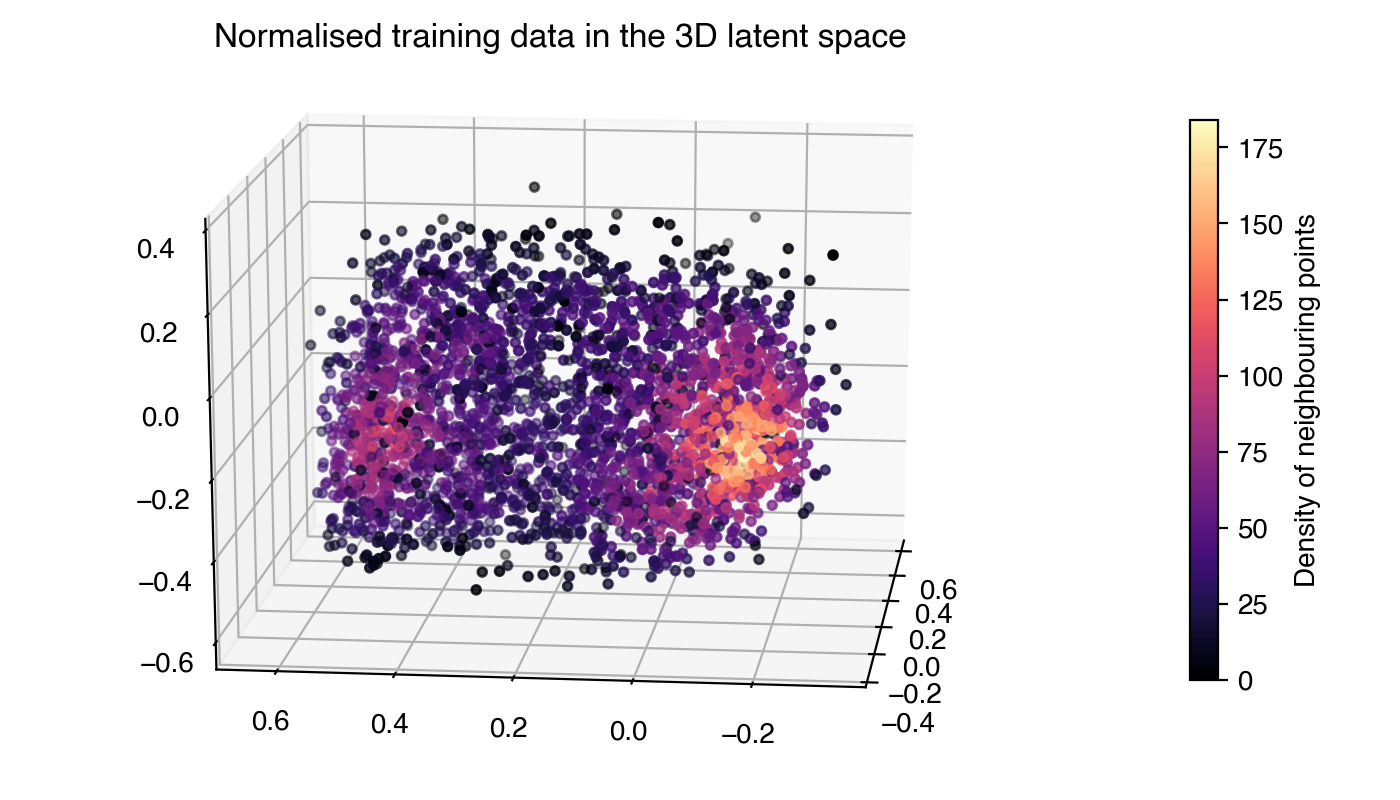

In [236]:
fig = plt.figure(figsize=(7, 4))
ax = Axes3D(fig)

im = ax.scatter3D(H_3_norm[:, 0], H_3_norm[:, 1], H_3_norm[:, 2], c=y_3_norm, s=10, cmap='magma')
ax.view_init(19, -174)
ax.set_title('Normalised training data in the 3D latent space')
fig.colorbar(im, ax=ax, shrink=0.7).set_label('Density of neighbouring points')
plt.savefig('ae_3_latent_norm.png', dpi=300)
fig.show()

In [336]:
d = 0.5
delta_x = torch.from_numpy(np.array([d, 0, 0])).type(torch.FloatTensor)
delta_y = torch.from_numpy(np.array([0, d, 0])).type(torch.FloatTensor)
delta_z = torch.from_numpy(np.array([0, 0, d])).type(torch.FloatTensor)

In [355]:
p = np.array([0.2, -0.5, -0.5])
point = torch.from_numpy(p).type(torch.FloatTensor)

In [356]:
x_plus = model_3_mm.decode(point + delta_x).clone().detach().numpy()
x_minus = model_3_mm.decode(point - delta_x).clone().detach().numpy()
y_plus = model_3_mm.decode(point + delta_y).clone().detach().numpy()
y_minus = model_3_mm.decode(point - delta_y).clone().detach().numpy()
z_plus = model_3_mm.decode(point + delta_z).clone().detach().numpy()
z_minus = model_3_mm.decode(point - delta_z).clone().detach().numpy()
pred = model_3_mm.decode(point).clone().detach().numpy()

<IPython.core.display.Javascript object>


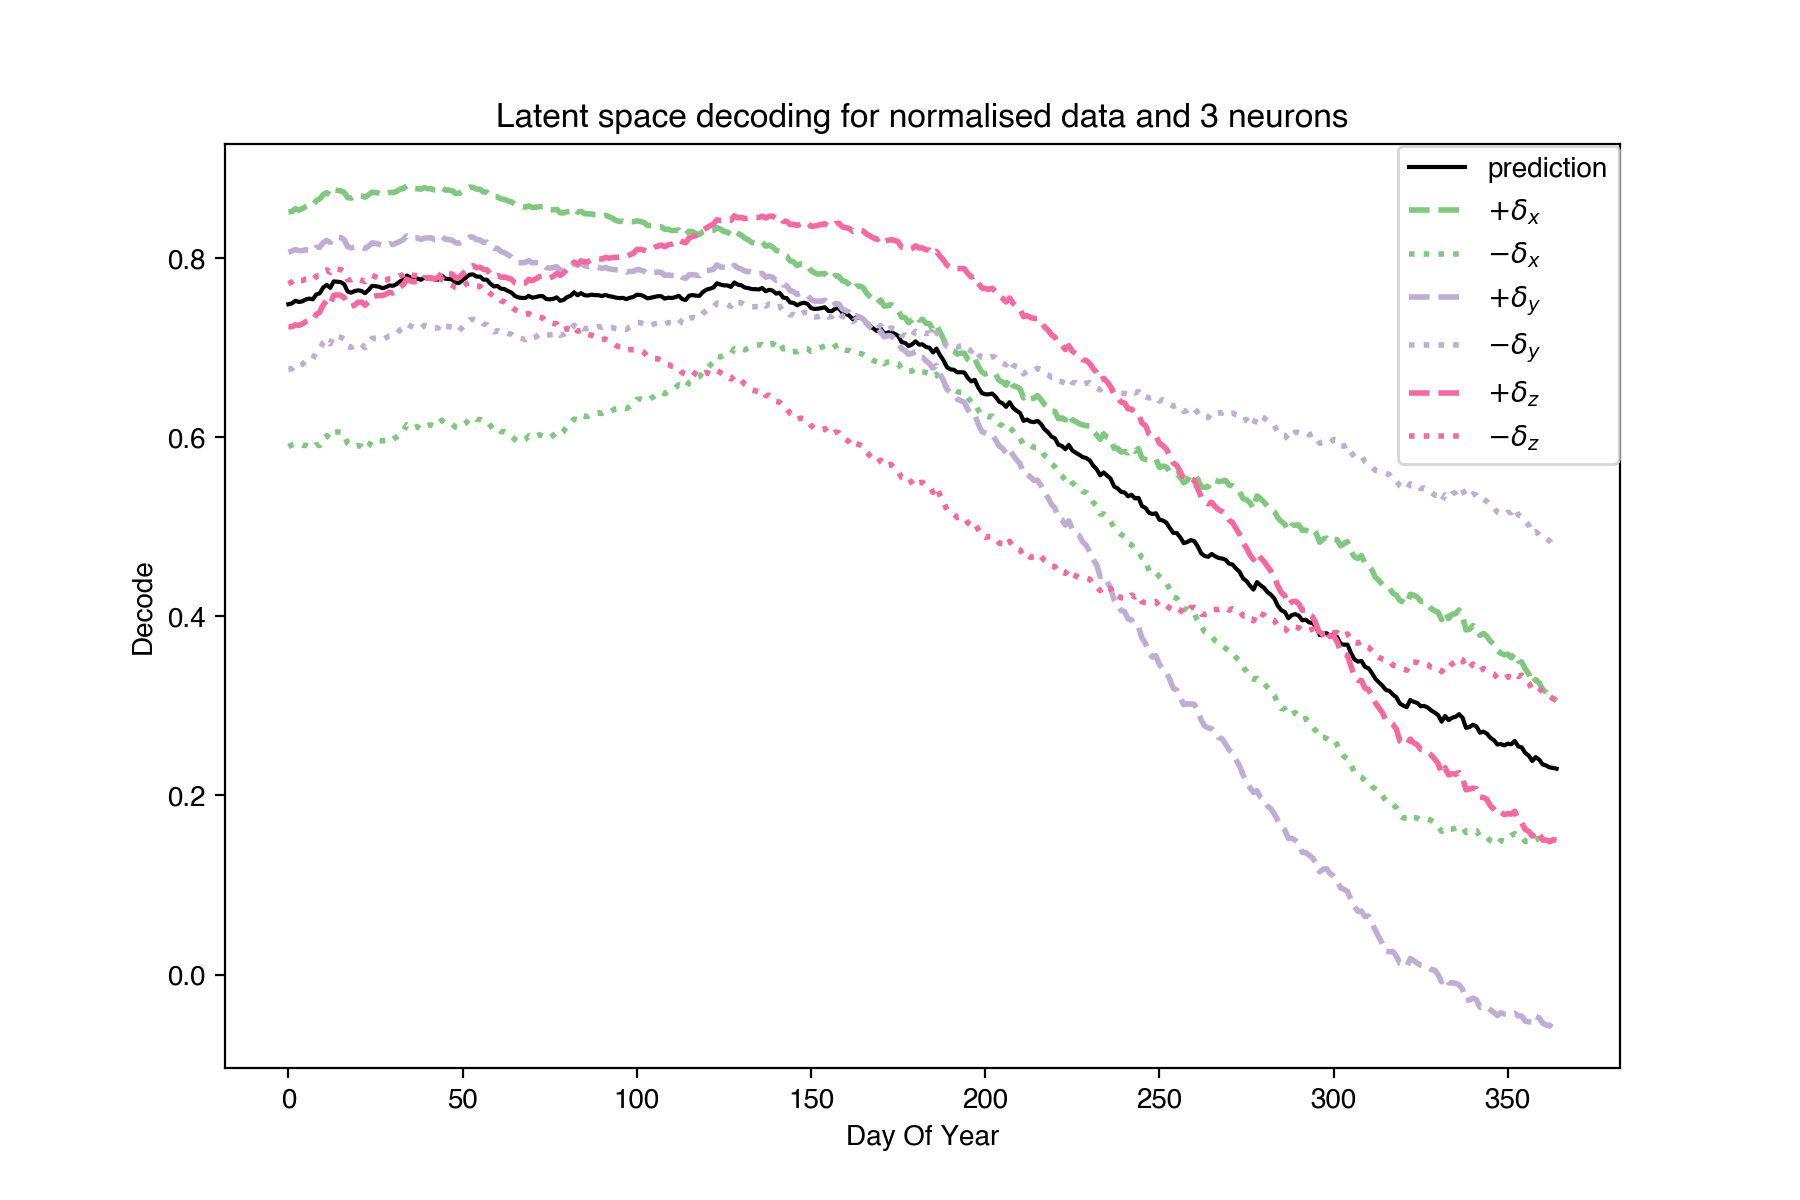

In [398]:
d = 0.2
delta_x = torch.from_numpy(np.array([d, 0, 0])).type(torch.FloatTensor)
delta_y = torch.from_numpy(np.array([0, d, 0])).type(torch.FloatTensor)
delta_z = torch.from_numpy(np.array([0, 0, d])).type(torch.FloatTensor)

p = np.array([0.3, 0.4, 0.1])
point = torch.from_numpy(p).type(torch.FloatTensor)

x_plus = model_3_mm.decode(point + delta_x).clone().detach().numpy()
x_minus = model_3_mm.decode(point - delta_x).clone().detach().numpy()
y_plus = model_3_mm.decode(point + delta_y).clone().detach().numpy()
y_minus = model_3_mm.decode(point - delta_y).clone().detach().numpy()
z_plus = model_3_mm.decode(point + delta_z).clone().detach().numpy()
z_minus = model_3_mm.decode(point - delta_z).clone().detach().numpy()
pred = model_3_mm.decode(point).clone().detach().numpy()


fig, ax = plt.subplots(figsize=(9,6))

ax.plot(pred, "-", label='prediction', color='black')
ax.plot(x_plus, "--", label=r'$+ \delta_x$', linewidth=2, color='#7fc97f')
ax.plot(x_minus, ":", label=r'$- \delta_x$', linewidth=2, color='#7fc97f')
ax.plot(y_plus, "--", label=r'$+ \delta_y$', linewidth=2, color='#beaed4')
ax.plot(y_minus, ":", label=r'$- \delta_y$', linewidth=2, color='#beaed4')
ax.plot(z_plus, "--", label=r'$+ \delta_z$', linewidth=2, color='#f768a1')
ax.plot(z_minus, ":", label=r'$- \delta_z$', linewidth=2, color='#f768a1')
ax.set_xlabel("Day Of Year")
ax.set_ylabel("Decode")
ax.set_title('Latent space decoding for normalised data and 3 neurons')

fig.legend(loc=1, bbox_to_anchor=(0.907, 0.89))
fig.show()
plt.savefig('ae_3_decode_norm.png', dpi=300)

### Standarised

#### 2

In [174]:
H_2_st = model_2_st.encode(test_st).clone().detach().numpy()
tree_2_st = spatial.KDTree(H_2_st)

In [175]:
r = 0.1
y_2_st = []
for point in H_2_st:
    y_2_st.append(len(tree_2_st.query_ball_point(point, r)) - 1)

<IPython.core.display.Javascript object>


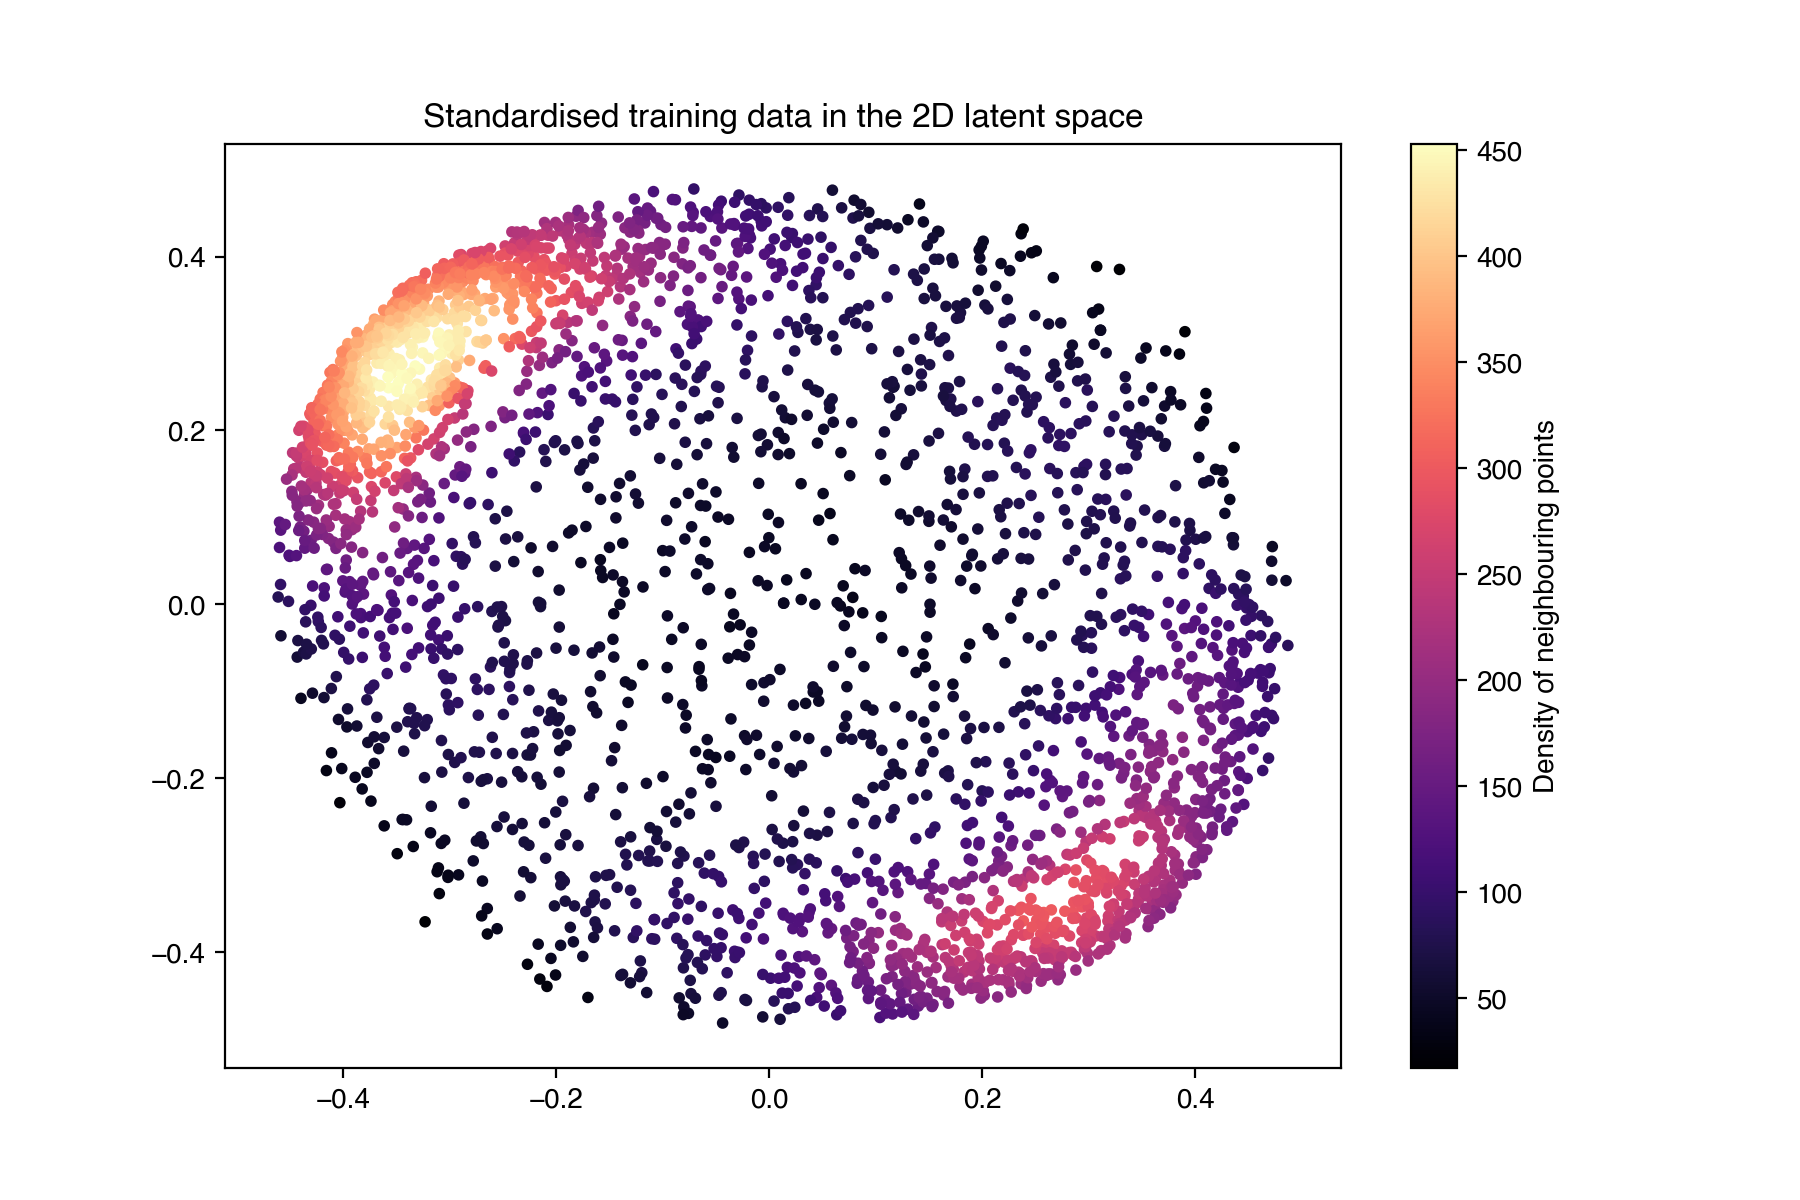

In [184]:
fig, ax = plt.subplots(figsize=(9,6))

im = ax.scatter(H_2_st[:, 0], H_2_st[:, 1], s=10, c=y_2_st, cmap='magma')
fig.colorbar(im, ax=ax).set_label('Density of neighbouring points')
ax.set_title('Standardised training data in the 2D latent space')

fig.show()
plt.savefig('ae_2_latent_st.png', dpi=300)

<IPython.core.display.Javascript object>


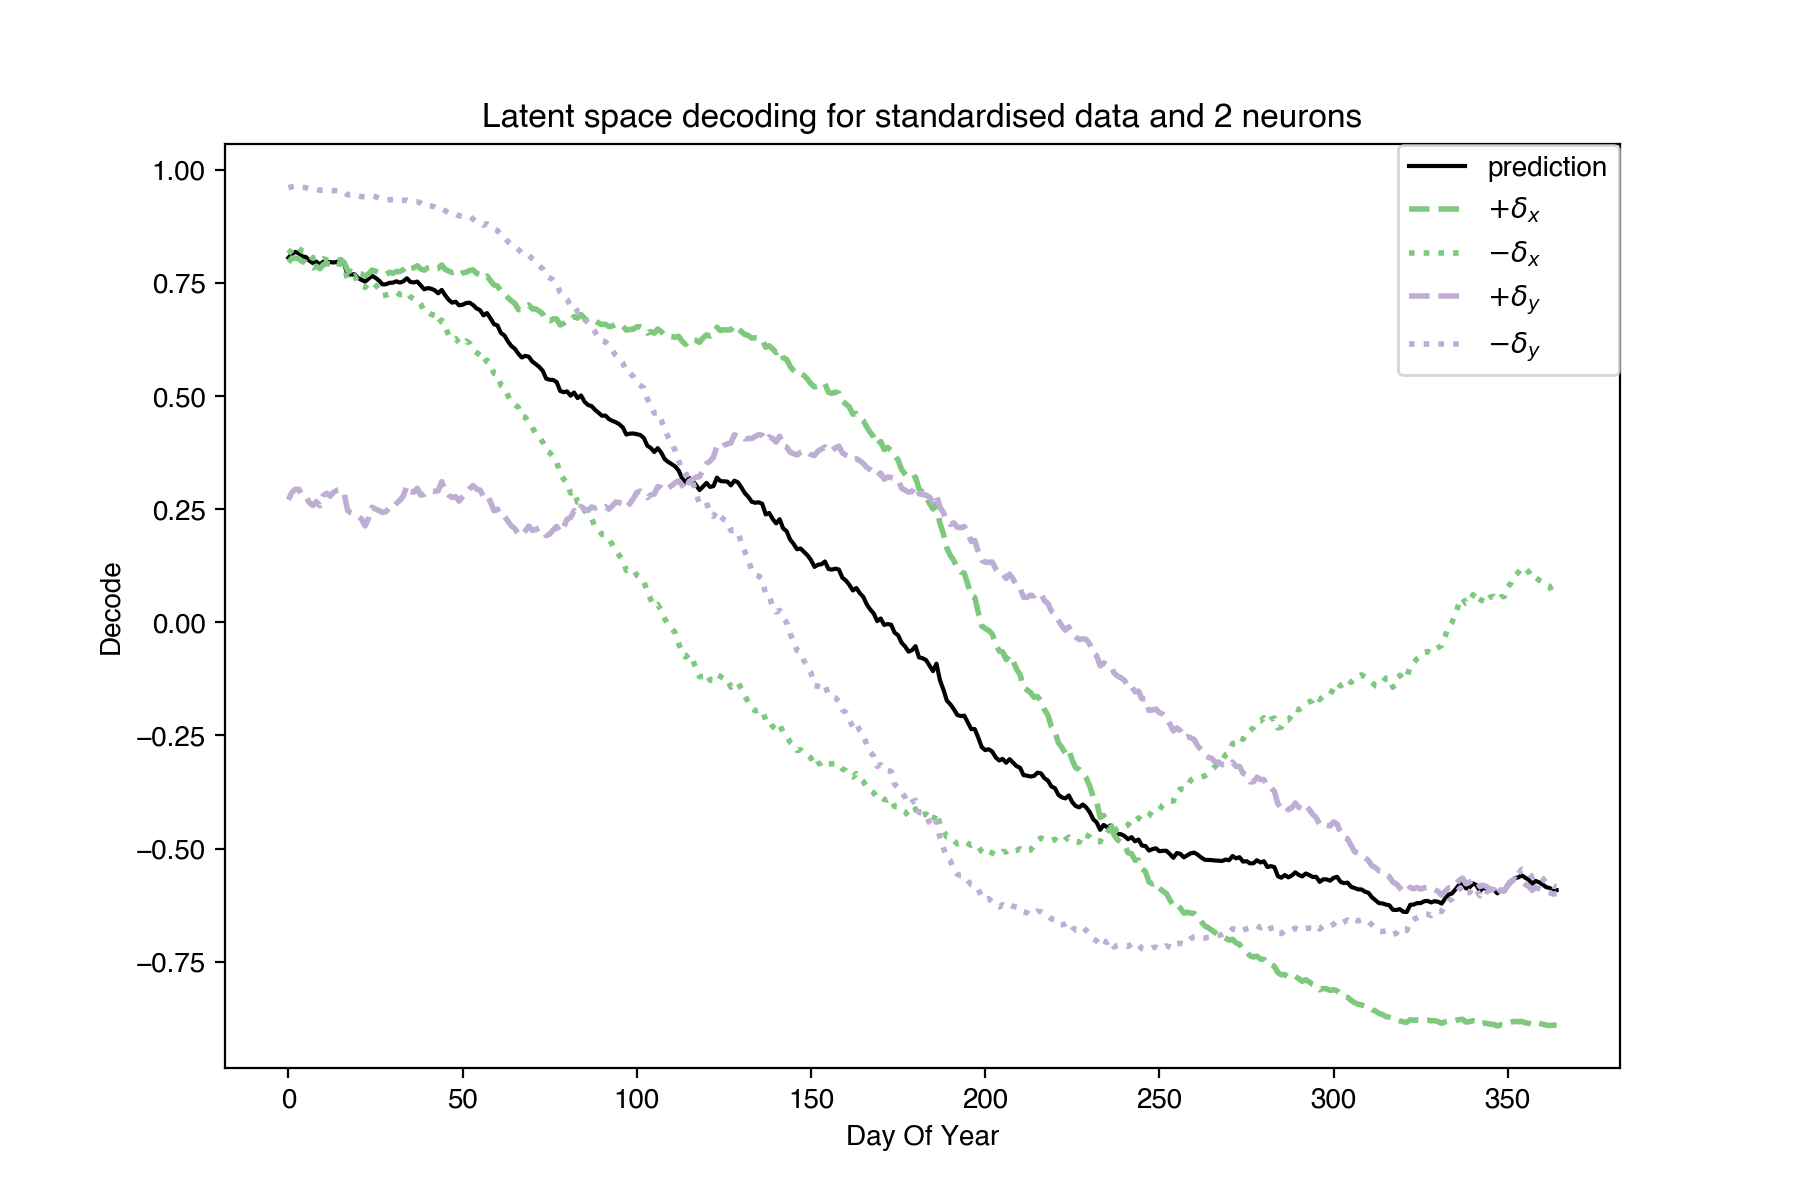

In [403]:
d = 0.2
delta_x = torch.from_numpy(np.array([d, 0])).type(torch.FloatTensor)
delta_y = torch.from_numpy(np.array([0, d])).type(torch.FloatTensor)

p = np.array([0.2, -0.25])
point = torch.from_numpy(p).type(torch.FloatTensor)

x_plus = model_2_st.decode(point + delta_x).clone().detach().numpy()
x_minus = model_2_st.decode(point - delta_x).clone().detach().numpy()
y_plus = model_2_st.decode(point + delta_y).clone().detach().numpy()
y_minus = model_2_st.decode(point - delta_y).clone().detach().numpy()
pred = model_2_st.decode(point).clone().detach().numpy()

fig, ax = plt.subplots(figsize=(9,6))

ax.plot(pred, "-", label='prediction', color='black')
ax.plot(x_plus, "--", label=r'$+ \delta_x$', linewidth=2, color='#7fc97f')
ax.plot(x_minus, ":", label=r'$- \delta_x$', linewidth=2, color='#7fc97f')
ax.plot(y_plus, "--", label=r'$+ \delta_y$', linewidth=2, color='#beaed4')
ax.plot(y_minus, ":", label=r'$- \delta_y$', linewidth=2, color='#beaed4')

ax.set_xlabel("Day Of Year")
ax.set_ylabel("Decode")
ax.set_title('Latent space decoding for standardised data and 2 neurons')
fig.legend(loc=1, bbox_to_anchor=(0.907, 0.891))
fig.show()
plt.savefig('ae_2_decode_st.png', dpi=300)

#### 3

In [224]:
H_3_st = model_3_st.encode(test_st).clone().detach().numpy()
tree_3_st = spatial.KDTree(H_3_st)

In [225]:
r = 0.1
y_3_st = []
for point in H_3_st:
    y_3_st.append(len(tree_3_st.query_ball_point(point, r)) - 1)

<IPython.core.display.Javascript object>


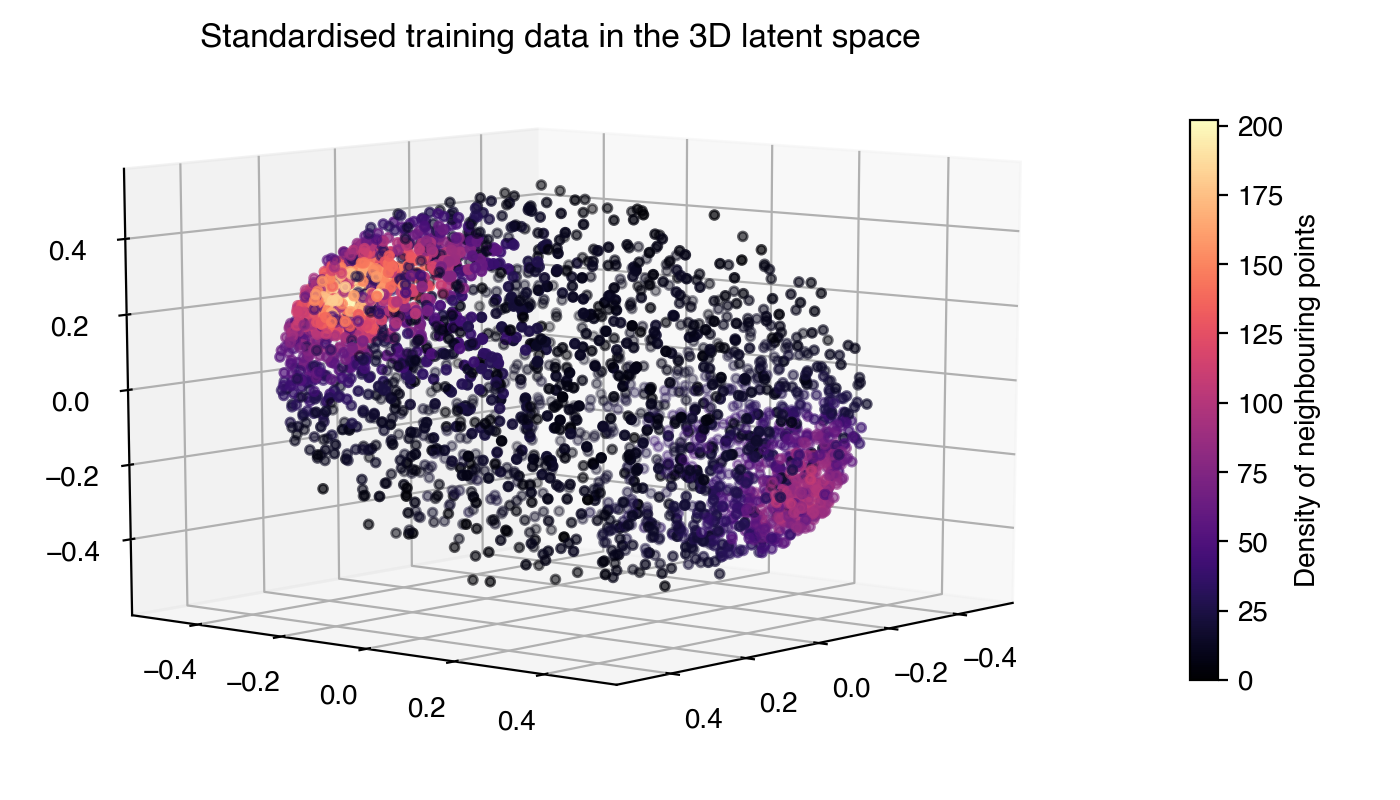

In [234]:
fig = plt.figure(figsize=(7, 4))
ax = Axes3D(fig)

im = ax.scatter3D(H_3_st[:, 0], H_3_st[:, 1], H_3_st[:, 2], c=y_3_st, s=10, cmap='magma')
ax.view_init(10, 40)
ax.set_title('Standardised training data in the 3D latent space')
fig.colorbar(im, ax=ax, shrink=0.7).set_label('Density of neighbouring points')
plt.savefig('ae_3_latent_st.png', dpi=300)
fig.show()

<IPython.core.display.Javascript object>


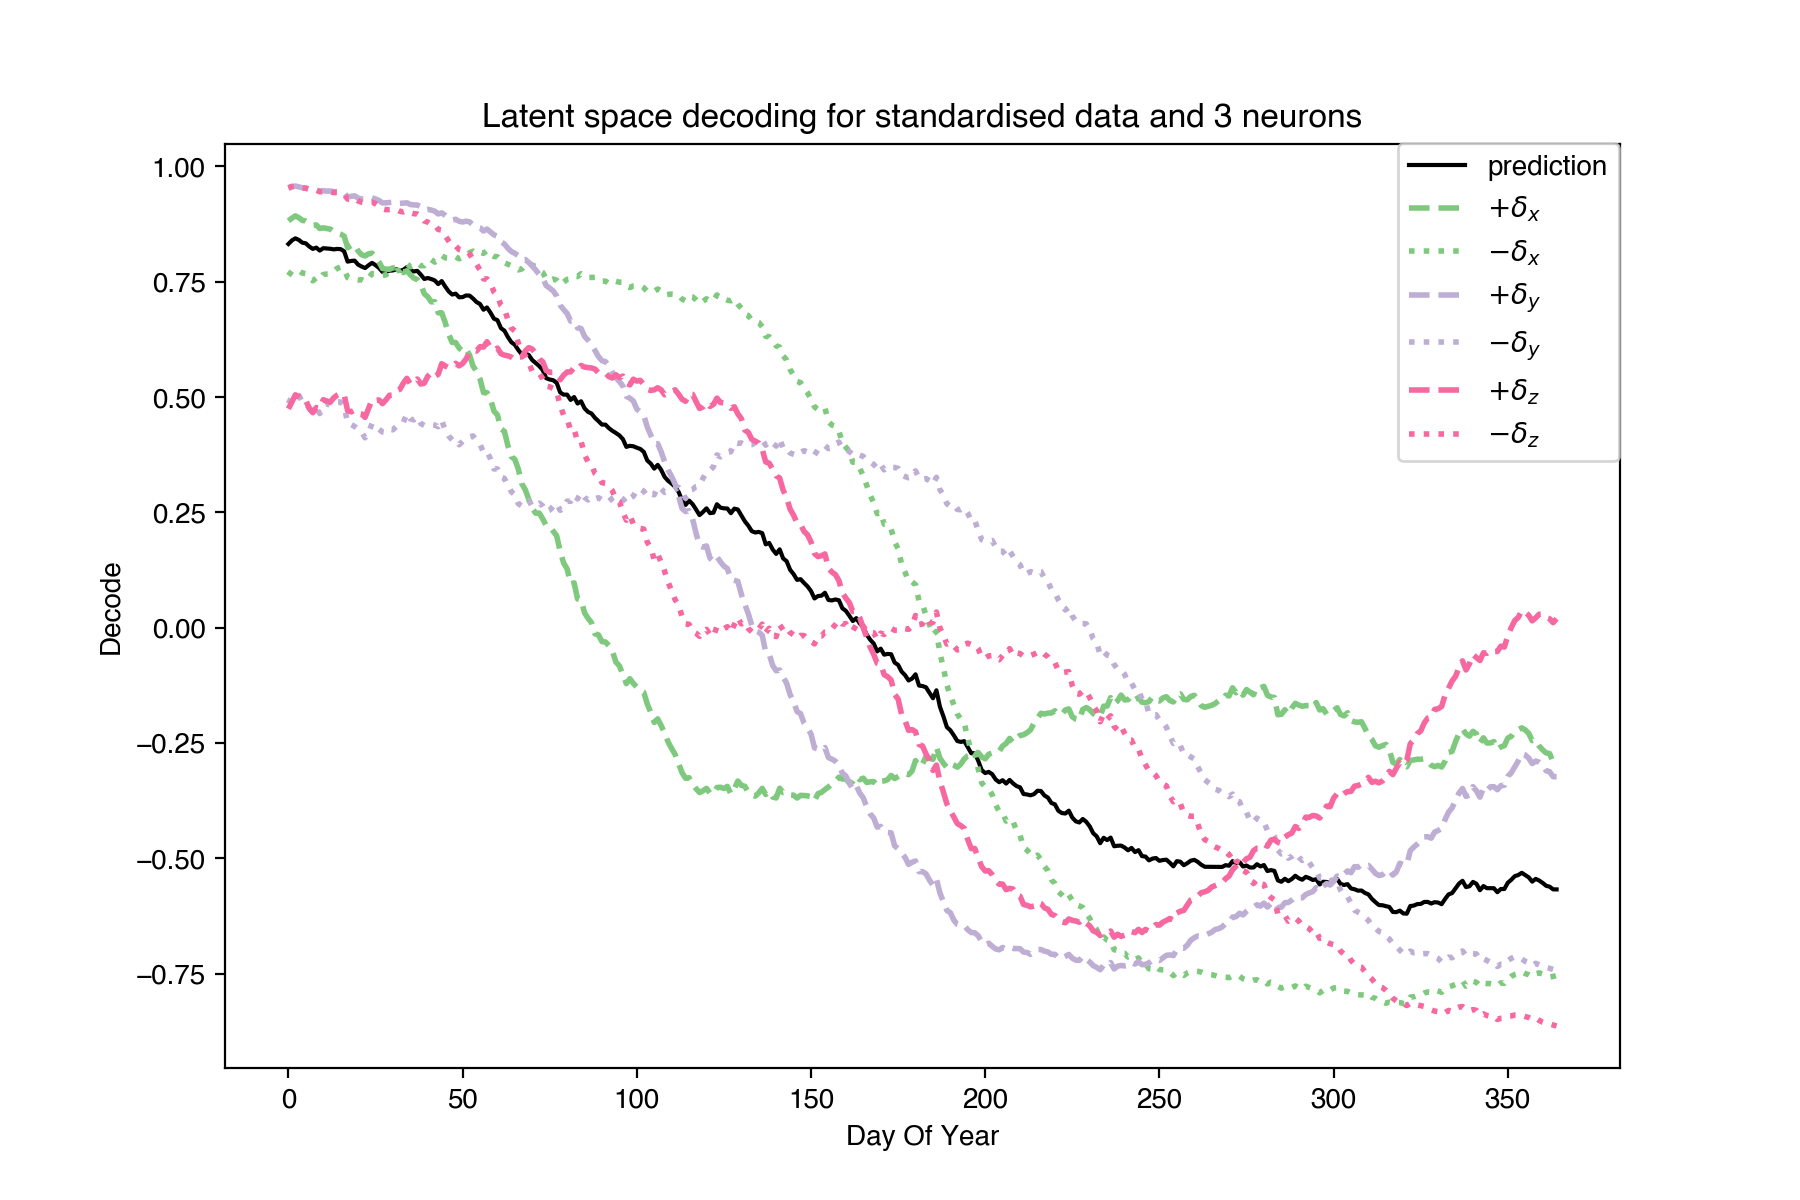

In [401]:
d = 0.2
delta_x = torch.from_numpy(np.array([d, 0, 0])).type(torch.FloatTensor)
delta_y = torch.from_numpy(np.array([0, d, 0])).type(torch.FloatTensor)
delta_z = torch.from_numpy(np.array([0, 0, d])).type(torch.FloatTensor)

p = np.array([-0.2, 0.2, -0.2])
point = torch.from_numpy(p).type(torch.FloatTensor)


x_plus = model_3_st.decode(point + delta_x).clone().detach().numpy()
x_minus = model_3_st.decode(point - delta_x).clone().detach().numpy()
y_plus = model_3_st.decode(point + delta_y).clone().detach().numpy()
y_minus = model_3_st.decode(point - delta_y).clone().detach().numpy()
z_plus = model_3_st.decode(point + delta_z).clone().detach().numpy()
z_minus = model_3_st.decode(point - delta_z).clone().detach().numpy()
pred = model_3_st.decode(point).clone().detach().numpy()


fig, ax = plt.subplots(figsize=(9,6))

ax.plot(pred, "-", label='prediction', color='black')
ax.plot(x_plus, "--", label=r'$+ \delta_x$', linewidth=2, color='#7fc97f')
ax.plot(x_minus, ":", label=r'$- \delta_x$', linewidth=2, color='#7fc97f')
ax.plot(y_plus, "--", label=r'$+ \delta_y$', linewidth=2, color='#beaed4')
ax.plot(y_minus, ":", label=r'$- \delta_y$', linewidth=2, color='#beaed4')
ax.plot(z_plus, "--", label=r'$+ \delta_z$', linewidth=2, color='#f768a1')
ax.plot(z_minus, ":", label=r'$- \delta_z$', linewidth=2, color='#f768a1')
ax.set_xlabel("Day Of Year")
ax.set_ylabel("Decode")
ax.set_title('Latent space decoding for standardised data and 3 neurons')

fig.legend(loc=1, bbox_to_anchor=(0.907, 0.892))
fig.show()
plt.savefig('ae_3_decode_st.png', dpi=300)